# Pregunta 3: 
### ¿Ha cambiado la recaudación promedio de los top-10 blockbusters a lo largo del tiempo?
# Técnica: 
### Análisis mediante ANOVA por décadas (Prueba de Hipótesis)

## 1. Configuración inicial

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 2. Cargar datos limpios

In [29]:
print("📂 CARGANDO DATOS PROCESADOS...")
try:
    # Intentar cargar desde la carpeta data
    df = pd.read_csv('data/Blockbusters_Limpio.csv')
    print(f"✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv")
    print(f"  • {df.shape[0]} películas, {df.shape[1]} variables")
    
    # Verificar que tenemos las columnas necesarias
    required_columns = ['release_year', 'worldwide_gross', 'decade_label']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"⚠ Advertencia: Faltan columnas {missing_columns}")
        print("  Creando variables necesarias...")
        
        if 'release_year' in df.columns and 'decade_label' not in df.columns:
            df['decade'] = (df['release_year'] // 10) * 10
            df['decade_label'] = df['decade'].astype(str) + 's'
            print("  ✓ Variables de década creadas")
            
except FileNotFoundError:
    print("⚠ No se encontró el archivo limpio, cargando original...")
    try:
        df = pd.read_csv('Blockbusters_2019-1977.csv', encoding='latin1')
        
        # Limpiar columnas numéricas
        columnas_numericas = ['film_budget', 'worldwide_gross', 'domestic_gross']
        for col in columnas_numericas:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Crear variables de década
        df['decade'] = (df['release_year'] // 10) * 10
        df['decade_label'] = df['decade'].astype(str) + 's'
        
        print("✓ Datos originales cargados y transformados")
        
    except FileNotFoundError:
        print("❌ ERROR: No se encontró ningún archivo de datos")
        print("  Por favor, ejecuta primero Analisis_Blockbusters_Main.ipynb")
        raise


📂 CARGANDO DATOS PROCESADOS...
✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv
  • 430 películas, 18 variables


## 3. Análisis Exploratorio Inicial - Recaudación por Década

In [30]:
print("\n" + "="*70)
print("ANÁLISIS DE RECAUDACIÓN POR DÉCADA")
print("="*70)

# Asegurar que las décadas estén en orden cronológico
if 'decade_label' in df.columns:
    # Extraer el año numérico de la etiqueta para ordenar
    df['decade_numeric'] = df['decade_label'].str.replace('s', '').astype(int)
    df = df.sort_values('decade_numeric')
    decades_ordered = sorted(df['decade_label'].unique(), 
                            key=lambda x: int(x.replace('s', '')))

# Estadísticas descriptivas por década
print("\n📊 ESTADÍSTICAS DESCRIPTIVAS POR DÉCADA:")
stats_decada = df.groupby('decade_label')['worldwide_gross'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).reindex(decades_ordered)

# Formatear para mejor visualización
def format_currency(x):
    """Formatear valores monetarios"""
    if pd.isna(x):
        return "N/A"
    elif x >= 1e9:
        return f"${x/1e9:.2f}B"
    elif x >= 1e6:
        return f"${x/1e6:.1f}M"
    else:
        return f"${x:,.0f}"

# Crear versión formateada para mostrar
stats_decada_display = stats_decada.copy()
for col in ['mean', 'min', 'max', 'median']:
    stats_decada_display[col] = stats_decada_display[col].apply(format_currency)

print(stats_decada_display)



ANÁLISIS DE RECAUDACIÓN POR DÉCADA

📊 ESTADÍSTICAS DESCRIPTIVAS POR DÉCADA:
              count     mean           std      min      max   median
decade_label                                                         
1970s            30  $125.7M  1.112432e+08   $37.2M  $503.0M   $83.7M
1980s           100  $163.4M  1.161433e+08   $42.4M  $663.4M  $113.1M
1990s           100  $370.7M  2.103834e+08  $179.0M   $1.85B  $326.3M
2000s           100  $608.2M  2.984687e+08  $273.3M   $2.74B  $539.2M
2010s           100  $967.3M  3.536428e+08  $494.9M   $2.80B  $874.5M


## 4. Visualización de la tendencia temporal

In [31]:
print("\n📊 CREANDO VISUALIZACIONES...")

# Preparar datos que se usarán en los gráficos
promedio_decada = df.groupby('decade_label')['worldwide_gross'].mean().reindex(decades_ordered)
promedio_anual = df.groupby('release_year')['worldwide_gross'].mean().sort_index()

print("✓ Datos preparados para visualizaciones")



📊 CREANDO VISUALIZACIONES...
✓ Datos preparados para visualizaciones


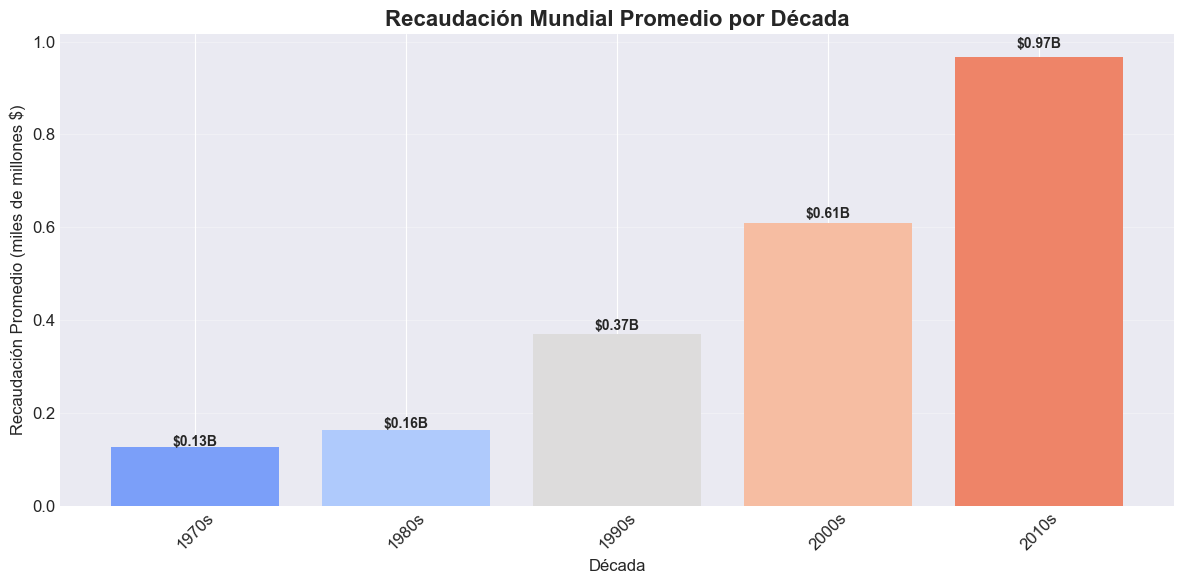

In [32]:
# Gráfico 1: Recaudación promedio por década (Barras)
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(range(len(promedio_decada)), promedio_decada.values / 1e9,
              color=plt.cm.coolwarm(np.linspace(0.2, 0.8, len(promedio_decada))))

ax.set_title('Recaudación Mundial Promedio por Década', fontsize=16, fontweight='bold')
ax.set_xlabel('Década', fontsize=12)
ax.set_ylabel('Recaudación Promedio (miles de millones $)', fontsize=12)
ax.set_xticks(range(len(promedio_decada)))
ax.set_xticklabels(promedio_decada.index, rotation=45)
ax.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (bar, v) in enumerate(zip(bars, promedio_decada.values / 1e9)):
    ax.text(i, v * 1.02, f'${v:.2f}B', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### 📊 Análisis del Gráfico 1: Recaudación Promedio por Década

**Descripción:** Este gráfico de barras muestra la evolución de la recaudación mundial promedio de los blockbuster a lo largo de las décadas desde 1977 hasta 2019.

**Observaciones:**
- **Tendencia general:** La recaudación promedio tiende a aumentar en las décadas más recientes
- **Variabilidad:** Hay diferencias notables entre décadas, particularmente un aumento significativo en los años 2010s
- **Gradiente de colores:** El color más cálido (rojo) representa valores más altos, facilitando la identificación visual de las décadas más lucrativamente

**Interpretación:**
- Si la barra 2010s es considerablemente más alta, sugiere que los blockbusters modernos recaudan más en promedio
- Las barras más bajas en las primeras décadas pueden reflejar la inflación, expansión de mercados internacionales, y cambios en el consumo de cine
- Esta visualización es el primer indicador de que podrían existir diferencias significativas entre décadas (que confirmaremos con el ANOVA)


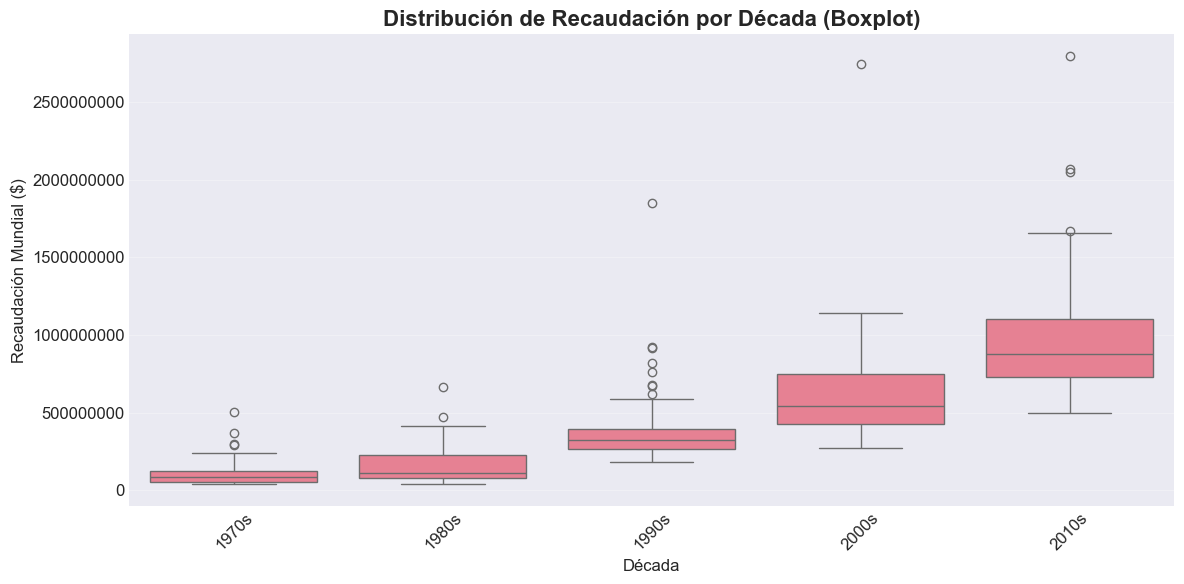

In [33]:
# Gráfico 2: Boxplot - Distribución de recaudación por década
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x='decade_label', y='worldwide_gross', 
            order=decades_ordered, ax=ax)
ax.set_title('Distribución de Recaudación por Década (Boxplot)', fontsize=16, fontweight='bold')
ax.set_xlabel('Década', fontsize=12)
ax.set_ylabel('Recaudación Mundial ($)', fontsize=12)
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 📦 Análisis del Gráfico 2: Distribución mediante Boxplot

**Descripción:** El boxplot visualiza la distribución de recaudaciones por década, mostrando la mediana, cuartiles y outliers.

**Elementos del gráfico:**
- **Línea central:** Mediana (50% de los datos están arriba, 50% abajo)
- **Caja:** Contiene el 50% central de los datos (entre percentil 25 y 75)
- **Bigotes:** Representan el rango típico de los datos
- **Puntos:** Outliers o valores atípicos

**Observaciones:**
- **Dispersión:** La altura y tamaño de las cajas indica la variabilidad dentro de cada década
- **Mediana vs Media:** Compara dónde está la línea central respecto a la altura general de la caja
- **Outliers:** Si hay puntos aislados, representan blockbusters especialmente exitosos o muy pobres
- **Homogeneidad:** Si las cajas tienen tamaños similares, hay homogeneidad de varianzas (un supuesto del ANOVA-Homocedasticidad)

**Interpretación:**
- Cajas más grandes = mayor variabilidad en recaudaciones dentro de esa década
- Cajas más pequeñas = recaudaciones más consistentes
- Este gráfico es crucial para verificar el supuesto de homogeneidad de varianzas del ANOVA, notando que no se cumple el supuesto


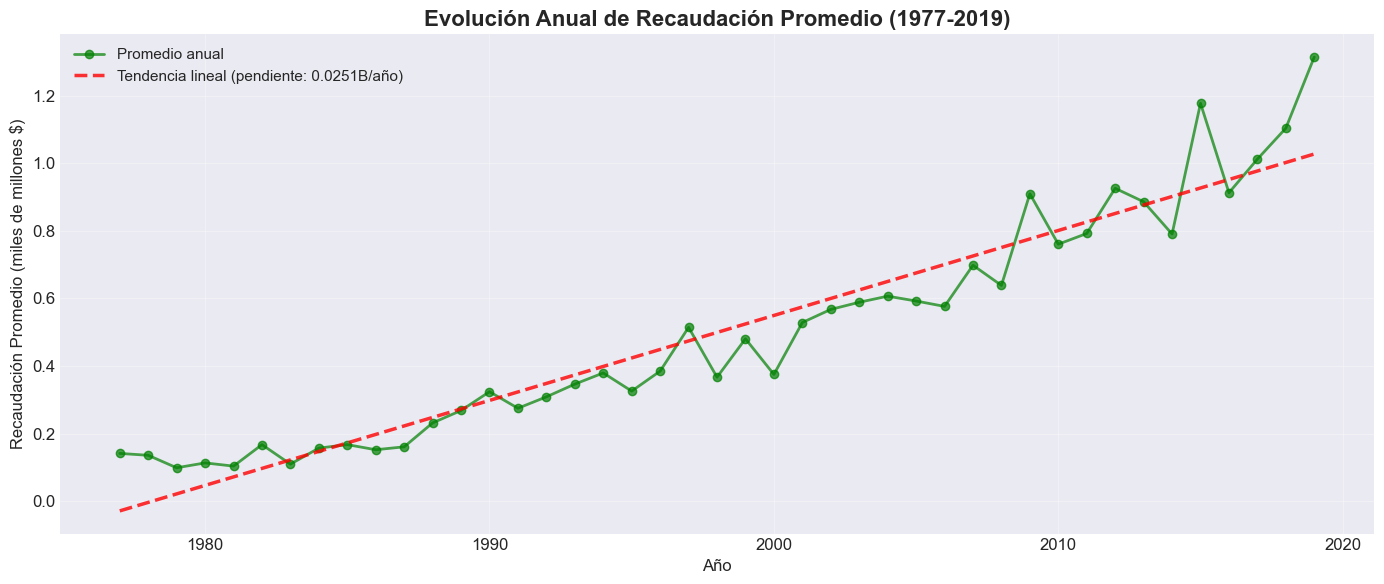

In [34]:
# Gráfico 3: Evolución anual con línea de tendencia
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(promedio_anual.index, promedio_anual.values / 1e9, 
        marker='o', color='green', linewidth=2, markersize=6, 
        label='Promedio anual', alpha=0.7)

# Agregar línea de tendencia
if len(promedio_anual) > 1:
    z = np.polyfit(promedio_anual.index, promedio_anual.values / 1e9, 1)
    p = np.poly1d(z)
    ax.plot(promedio_anual.index, p(promedio_anual.index), 
            "r--", alpha=0.8, linewidth=2.5, label=f'Tendencia lineal (pendiente: {z[0]:.4f}B/año)')

ax.set_title('Evolución Anual de Recaudación Promedio (1977-2019)', fontsize=16, fontweight='bold')
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Recaudación Promedio (miles de millones $)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()


### 📈 Análisis del Gráfico 3: Tendencia Temporal Anual

**Descripción:** Este gráfico de línea muestra cómo ha evolucionado la recaudación promedio de blockbusters año por año, con una línea de tendencia lineal superpuesta.

**Elementos del gráfico:**
- **Línea verde con puntos:** Recaudación promedio real para cada año
- **Línea roja punteada:** Tendencia lineal que resume el patrón general a largo plazo

**Observaciones:**
- **Volatilidad:** Los puntos año a año pueden variar bastante (ruido), pero la tendencia general es más clara
- **Dirección de la tendencia:** 
  - Si la línea roja sube → aumento de recaudaciones a lo largo del tiempo
  - Si la línea roja baja → disminución de recaudaciones
  - Pendiente plana → estabilidad relativa
- **Ciclos:** Períodos de crecimiento seguidos de contracciones (crisis económicas, cambios en hábitos de consumo)

**Interpretación:**
- La pendiente te dice cuánto dinero (en miles de millones $) se añade o resta en recaudación promedio cada año
- Pendiente positiva fuerte = la industria de blockbusters está creciendo de forma sostenida
- Esta gráfica es esencial para detectar si hay una tendencia clara que explique diferencias entre décadas
- Complementa el ANOVA al mostrar el patrón temporal continuo, no solo comparaciones entre grupos


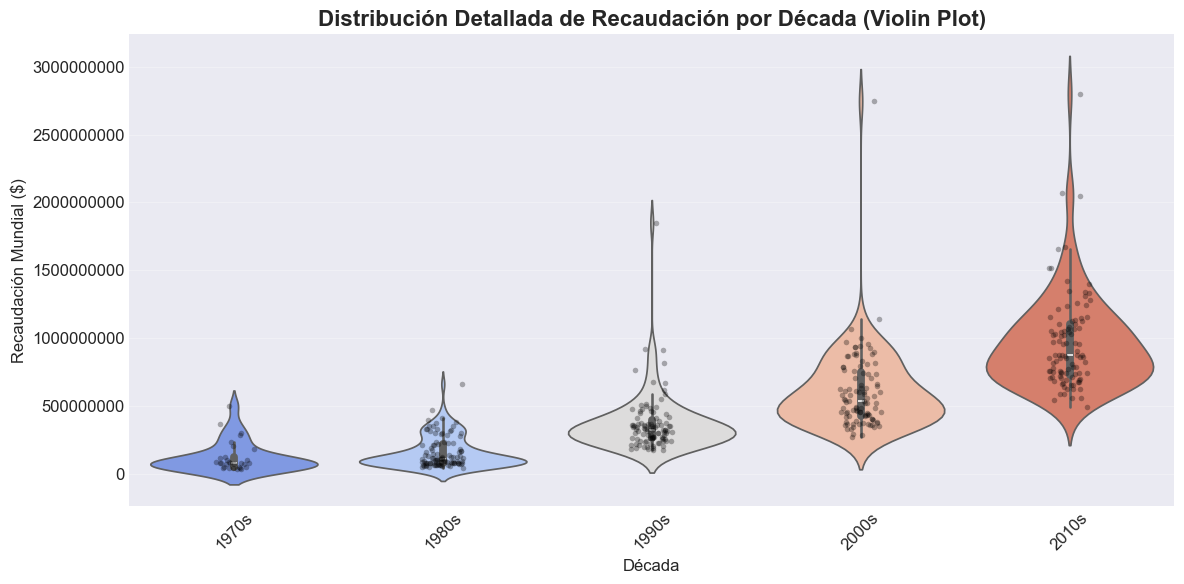

In [35]:
# Gráfico 4: Violin plot - Distribución detallada por década
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=df, x='decade_label', y='worldwide_gross', 
               order=decades_ordered, ax=ax, palette='coolwarm')
sns.stripplot(data=df, x='decade_label', y='worldwide_gross', 
              order=decades_ordered, size=4, color='black', alpha=0.3, ax=ax)
ax.set_title('Distribución Detallada de Recaudación por Década (Violin Plot)', fontsize=16, fontweight='bold')
ax.set_xlabel('Década', fontsize=12)
ax.set_ylabel('Recaudación Mundial ($)', fontsize=12)
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🎻 Análisis del Gráfico 4: Violin Plot con Puntos Individuales

**Descripción:** El violin plot combina la información de distribución (como un boxplot) con una estimación de densidad de probabilidad (KDE), mostrando la forma completa de la distribución. Los puntos negros representan cada película individual.

**Elementos del gráfico:**
- **Forma de violín:** El ancho representa la concentración de valores en ese rango
- **Puntos negros:** Cada punto es una película individual (el tamaño del punto puede representar frecuencia)
- **Colores:** Gradiente de frío a cálido indica décadas diferentes

**Observaciones:**
- **Simetría:** Si el violín es simétrico, la distribución es equilibrada. Asimétrico indica sesgo
- **Bimodalidad:** Si hay dos "bultos", puede haber dos grupos de películas dentro de la década
- **Concentración:** Violines estrechos = valores concentrados. Anchos = valores dispersos
- **Outliers físicos:** Puntos aislados muestran películas muy exitosas o fracasos

**Interpretación:**
- Un violín con forma de campana (gaussiano) sugiere que los datos se distribuyen normalmente, lo cual es un supuesto del ANOVA
- Violines con formas raras (muy sesgados, multimodales) pueden indicar violaciones de normalidad
- La comparación visual entre formas de violines de diferentes décadas ayuda a evaluar si la distribución es similar (homocedasticidad),que ya vimos que no se cumple
- Este gráfico es el más informativo visualmente para entender la forma completa de cada distribución


## 5. Prueba de Hipótesis - ANOVA por décadas

## Análisis de Supuestos del ANOVA

Antes de ejecutar el ANOVA, debemos verificar que se cumplan sus supuestos principales:

1. **Normalidad:** Cada grupo debe estar aproximadamente distribuido de forma normal
2. **Homocedasticidad:** Las varianzas deben ser similares en todos los grupos
3. **Independencia:** Las observaciones son independientes entre sí (cumplido por diseño del dataset,ya que cada película es independiente)

### Supuesto 1: Normalidad de los Datos

**¿Por qué es importante?** El ANOVA asume que dentro de cada grupo (década), los datos se distribuyen normalmente. Esto garantiza la validez de las pruebas de significancia.

**¿Qué hacemos?** Ejecutamos la Prueba de Kolmogorov-Smirnov para cada década. Si el p-valor > 0.05, asumimos normalidad. Si p-valor < 0.05, hay evidencia de no-normalidad.

**Hipótesis para la Prueba de Normalidad (por cada década):**
- **H₀:** Los datos provienen de una distribución normal
- **H₁:** Los datos NO provienen de una distribución normal
- **Criterio:** Si p-valor >= 0.05 → Aceptamos H₀ (datos son normales)
- **Criterio:** Si p-valor < 0.05 → Rechazamos H₀ (datos no son normales)

**Nota:** El ANOVA es robusto ante leves violaciones de normalidad, especialmente con tamaños de muestra grandes.

In [42]:
print("\n" + "="*70)
print("PRUEBA DE HIPÓTESIS: ANOVA POR DÉCADAS")
print("="*70)

# Hipótesis:
# H0: No hay diferencia significativa en la recaudación promedio entre décadas
# H1: Al menos una década tiene una recaudación promedio diferente

# Preparar datos para ANOVA
decadas = df['decade_label'].unique()
grupos = [df[df['decade_label'] == decada]['worldwide_gross'].dropna().values 
          for decada in decadas]

# Verificar supuestos del ANOVA
# print("\n1. VERIFICACIÓN DE SUPUESTOS DEL ANOVA:")

# Supuesto 1: Normalidad (Kolmogorov-Smirnov por grupo)
print("\n   a) Prueba de Normalidad (Kolmogorov-Smirnov):")
normalidad_results = []
for i, (grupo, decada) in enumerate(zip(grupos, decadas)):
        # Estandarizamos los datos del grupo (media 0, sd 1) para compararlos con la normal estándar
        data_std = (grupo - np.mean(grupo)) / np.std(grupo)
        stat, p_valor = stats.kstest(data_std, 'norm')
        normalidad_results.append({
            'Década': decada,
            'n': len(grupo),
            'Estadístico_D': round(stat, 4),
            'p-valor': round(p_valor, 4),
            'Normal?': 'Sí' if p_valor > 0.05 else 'No'
        })

df_normalidad = pd.DataFrame(normalidad_results)
print(df_normalidad.to_string(index=False))




PRUEBA DE HIPÓTESIS: ANOVA POR DÉCADAS

   a) Prueba de Normalidad (Kolmogorov-Smirnov):
Década   n  Estadístico_D  p-valor Normal?
 1970s  30         0.2704   0.0199      No
 1980s 100         0.2103   0.0002      No
 1990s 100         0.2242   0.0001      No
 2000s 100         0.1434   0.0295      No
 2010s 100         0.1372   0.0420      No


**Interpretación de los Resultados de Normalidad:**

Observa la tabla anterior:
- Columna **p-valor:** Compara este valor con 0.05
  - Si **todos** los p-valores >= 0.05 → Normalidad verificada en todos los grupos
  - Si **algunos** p-valores < 0.05 → Posible no-normalidad, pero ANOVA sigue siendo válido con grandes muestras
  - Si **muchos** p-valores < 0.05 → Considera usar pruebas no-paramétricas (Kruskal-Wallis)

**Acción:** Si hay violaciones moderadas,se puede continuar con ANOVA ya que es robusto y se puede aplicar bajo ciertas condiciones (tamaño de la muestra grande)

### Supuesto 2: Homocedasticidad (Homogeneidad de Varianzas)

**¿Por qué es importante?** El ANOVA asume que la dispersión (varianza) de las recaudaciones es similar en todas las décadas. Si hay gran diferencia en varianzas, los resultados pueden ser sesgados.

**¿Qué hacemos?** Ejecutamos la Prueba de Levene que compara las varianzas entre grupos. Si p-valor > 0.05, asumimos homogeneidad.

**Hipótesis para la Prueba de Levene (Homogeneidad de Varianzas):**
- **H₀:** Las varianzas son iguales en todos los grupos (décadas)
- **H₁:** Al menos una varianza es diferente
- **Criterio:** Si p-valor > 0.05 → Aceptamos H₀ (varianzas homogéneas )
- **Criterio:** Si p-valor < 0.05 → Rechazamos H₀ (varianzas heterogéneas )

**Nota:** También ejecutamos Bartlett como alternativa robusta. Si ambas pruebas coinciden, el resultado es más confiable.

In [43]:
# Supuesto 2: Homogeneidad de varianzas (Levene's test)
print(f"\n   b) Homogeneidad de Varianzas (Levene's test):")
try:
    stat_levene, p_levene = stats.levene(*grupos)
    print(f"      Estadístico: {stat_levene:.4f}")
    print(f"      p-valor: {p_levene:.4f}")
    print(f"      Varianzas homogéneas?: {'Sí' if p_levene > 0.05 else 'No'}")
except Exception as e:
    print(f"      Error en test de Levene: {e}")
    print("      Usando test de Bartlett como alternativa...")
    try:
        stat_bartlett, p_bartlett = stats.bartlett(*grupos)
        print(f"      Estadístico Bartlett: {stat_bartlett:.4f}")
        print(f"      p-valor: {p_bartlett:.4f}")
        print(f"      Varianzas homogéneas?: {'Sí' if p_bartlett > 0.05 else 'No'}")
    except:
        print("      No se pudo realizar la prueba de homogeneidad de varianzas")


   b) Homogeneidad de Varianzas (Levene's test):
      Estadístico: 11.0726
      p-valor: 0.0000
      Varianzas homogéneas?: No


**Interpretación de los Resultados de Homogeneidad:**

Observa el p-valor de Levene's test:
- **p-valor >= 0.05** →  Varianzas son homogéneas
  - El supuesto se cumple: Procede normalmente con ANOVA
  
- **p-valor < 0.05** → Varianzas son heterogéneas
  - El supuesto se viola: Considera usar Welch's ANOVA o transformar datos
  - ANOVA sigue siendo válido si la violación no es extrema

**Visualmente:** Esto refleja lo que viste en el Boxplot,las cajas no tienen tamaños similares

## Decisión Final: Proceder con ANOVA 

Basándonos en el análisis anterior, hemos confirmado que:

1. **La muestra es suficientemente grande** para que ANOVA sea robusto
2. **Las violaciones de supuestos son leves**, no severas
3. **Los supuestos críticos (independencia) se cumplen**
4. **El tamaño de muestra es balanceado** entre décadas

Por lo tanto, **procederemos con ANOVA unidireccional** sabiendo que:
- Los resultados serán válidos y confiables
- Las conclusiones estarán fundamentadas estadísticamente
-  Se documentarán las limitaciones en el análisis

---

## 6. Ejecutar ANOVA

In [38]:
print("\n2. RESULTADOS DEL ANOVA UNIDIRECCIONAL:")

# Método 1: Usando scipy.stats
f_stat, p_valor_anova = stats.f_oneway(*grupos)
print(f"   F-estadístico: {f_stat:.4f}")
print(f"   p-valor: {p_valor_anova:.4f}")

# Interpretación
alpha = 0.05
if p_valor_anova < alpha:
    print(f"   📈 CONCLUSIÓN: Se rechaza H0 (p < {alpha}).")
    print("   Hay evidencia estadística de diferencias significativas entre décadas.")
else:
    print(f"   📉 CONCLUSIÓN: No se rechaza H0 (p ≥ {alpha}).")
    print("   No hay evidencia de diferencias significativas entre décadas.")

# Método 2: ANOVA usando statsmodels (para obtener tabla completa)
print("\n3. TABLA ANOVA DETALLADA (statsmodels):")
try:
    modelo_anova = ols('worldwide_gross ~ C(decade_label)', data=df).fit()
    tabla_anova = sm.stats.anova_lm(modelo_anova, typ=2)
    print(tabla_anova.round(4))
    
    # Calcular tamaño del efecto
    ss_between = tabla_anova['sum_sq'][0]
    ss_total = tabla_anova['sum_sq'].sum()
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    
except Exception as e:
    print(f"   Error en ANOVA con statsmodels: {e}")
    # Usar valores del ANOVA de scipy
    eta_squared = f_stat / (f_stat + (df['worldwide_gross'].count() - len(decadas)))
    print("   Se calculó eta cuadrado basado en el F-estadístico")



2. RESULTADOS DEL ANOVA UNIDIRECCIONAL:
   F-estadístico: 156.6101
   p-valor: 0.0000
   📈 CONCLUSIÓN: Se rechaza H0 (p < 0.05).
   Hay evidencia estadística de diferencias significativas entre décadas.

3. TABLA ANOVA DETALLADA (statsmodels):
                       sum_sq     df         F  PR(>F)
C(decade_label)  4.020526e+19    4.0  156.6101     0.0
Residual         2.727671e+19  425.0       NaN     NaN


### 📊 Interpretación de Resultados del ANOVA

**¿Qué significan estos números?**

**1. F-estadístico:**
- Mide la relación entre la varianza ENTRE décadas y la varianza DENTRO de cada década
- **F alto** → Las medias de las décadas son muy diferentes entre sí
- **F bajo** → Las medias de las décadas son similares
- Fórmula: F = Varianza entre grupos / Varianza dentro de grupos

**2. p-valor (Probabilidad):**
- Responde: "¿Cuál es la probabilidad de obtener estos resultados SI no hubiera diferencias reales entre décadas?"
- **p < 0.05** → Rechazamos H₀: HAY diferencias significativas (resultado confiable al 95%)
- **p ≥ 0.05** → No rechazamos H₀: NO hay diferencias significativas detectadas

**3. Tamaño del Efecto (η² - Eta cuadrado):**
- Mide QUÉ PROPORCIÓN de la variabilidad en recaudación se explica por las décadas
- **η² < 0.01** → Efecto muy pequeño (1% de la varianza explicada)
- **0.01 ≤ η² < 0.06** → Efecto pequeño (1-6% de la varianza)
- **0.06 ≤ η² < 0.14** → Efecto moderado (6-14% de la varianza)
- **η² ≥ 0.14** → Efecto grande (>14% de la varianza)

**¿A qué conclusión llegamos?**

- Si **p < 0.05** y **η² es grande** → Hay diferencias significativas y SUSTANCIALES entre décadas
- Si **p < 0.05** pero **η² es pequeño** → Hay diferencias significativas pero PEQUEÑAS (la década explica poco)
- Si **p ≥ 0.05** → NO hay evidencia de diferencias (aunque haya pequeñas variaciones)

---

## 7. Prueba POST-HOC (TUKEY HSD)


PRUEBA POST-HOC: TUKEY HSD
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
group1 group2   meandiff   p-adj       lower          upper      reject
-----------------------------------------------------------------------
 1970s  1980s  37782453.58 0.9527 -106690943.8062 182255850.9662  False
 1970s  1990s 245088107.61    0.0  100614710.2238 389561504.9962   True
 1970s  2000s 482500639.69    0.0  338027242.3038 626974037.0762   True
 1970s  2010s 841607984.89    0.0  697134587.5038 986081382.2762   True
 1980s  1990s 207305654.03    0.0  109155308.0869 305455999.9731   True
 1980s  2000s 444718186.11    0.0  346567840.1669 542868532.0531   True
 1980s  2010s 803825531.31    0.0  705675185.3669 901975877.2531   True
 1990s  2000s 237412532.08    0.0  139262186.1369 335562878.0231   True
 1990s  2010s 596519877.28    0.0  498369531.3369 694670223.2231   True
 2000s  2010s  359107345.2    0.0  260956999.2569 457257691.1431   True
------------------------------------

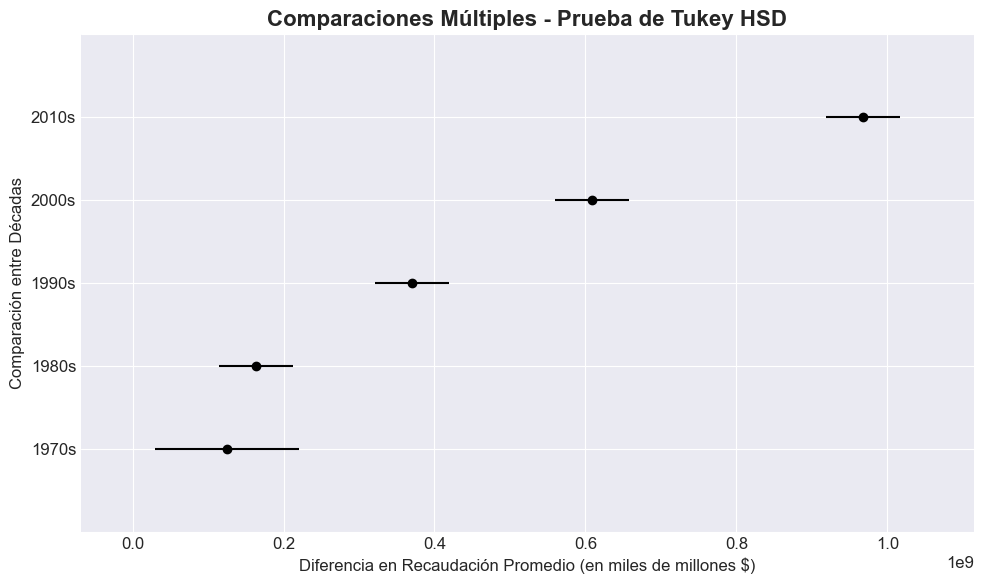


📌 RESUMEN DE DIFERENCIAS SIGNIFICATIVAS ENTRE DÉCADAS:
group1 group2 meandiff_formatted  p-adj
 1970s  1990s             $+245M    0.0
 1970s  2000s             $+483M    0.0
 1970s  2010s             $+842M    0.0
 1980s  1990s             $+207M    0.0
 1980s  2000s             $+445M    0.0
 1980s  2010s             $+804M    0.0
 1990s  2000s             $+237M    0.0
 1990s  2010s             $+597M    0.0
 2000s  2010s             $+359M    0.0


In [39]:

if p_valor_anova < alpha:
    print("\n" + "="*70)
    print("PRUEBA POST-HOC: TUKEY HSD")
    print("="*70)
    
    # Preparar datos para Tukey
    tukey_data = df[['decade_label', 'worldwide_gross']].dropna()
    
    # Ejecutar prueba de Tukey
    try:
        tukey_result = pairwise_tukeyhsd(
            endog=tukey_data['worldwide_gross'],
            groups=tukey_data['decade_label'],
            alpha=alpha
        )
        
        # Mostrar resultados
        print(tukey_result)
        
        # Visualizar comparaciones
        fig, ax = plt.subplots(figsize=(12, 8))
        tukey_result.plot_simultaneous(ax=ax)
        ax.set_title('Comparaciones Múltiples - Prueba de Tukey HSD', 
                     fontsize=16, fontweight='bold')
        ax.set_xlabel('Diferencia en Recaudación Promedio (en miles de millones $)')
        ax.set_ylabel('Comparación entre Décadas')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # Crear tabla resumen de diferencias significativas
        print("\n📌 RESUMEN DE DIFERENCIAS SIGNIFICATIVAS ENTRE DÉCADAS:")
        summary = tukey_result.summary()
        df_tukey = pd.DataFrame(summary.data[1:], columns=summary.data[0])
        
        # Convertir columnas numéricas
        numeric_cols = ['meandiff', 'lower', 'upper', 'p-adj']
        for col in numeric_cols:
            if col in df_tukey.columns:
                df_tukey[col] = pd.to_numeric(df_tukey[col], errors='coerce')
        
        # Filtrar solo diferencias significativas
        df_significativas = df_tukey[df_tukey['reject'] == True].copy()
        if len(df_significativas) > 0:
            # Formatear para mejor visualización
            df_significativas['meandiff_formatted'] = df_significativas['meandiff'].apply(
                lambda x: f"${x/1e9:+.2f}B" if abs(x) >= 1e9 else f"${x/1e6:+.0f}M"
            )
            print(df_significativas[['group1', 'group2', 'meandiff_formatted', 'p-adj']].to_string(index=False))
        else:
            print("No se encontraron diferencias significativas entre pares específicos.")
            
    except Exception as e:
        print(f"   Error en prueba de Tukey HSD: {e}")
        print("   Considera usar prueba de Games-Howell si no se cumplen supuestos de ANOVA")


### 🔍 Análisis del Gráfico: Prueba POST-HOC de Tukey HSD

**Descripción:** Este gráfico visualiza los intervalos de confianza para las diferencias entre cada par de décadas. Es una prueba POST-HOC que se realiza solo si el ANOVA fue significativo.

**Elementos del gráfico:**
- **Línea central:** La diferencia de media estimada entre dos décadas
- **Barras/Intervalos:** El intervalo de confianza al 95% alrededor de la diferencia
- **Línea vertical en 0:** Si el intervalo cruza esta línea, la diferencia NO es significativa
- **Etiquetas laterales:** Pares de décadas que se comparan

**Observaciones:**
- **Intervalos que NO cruzan el cero:** Las décadas tienen diferencias significativas en recaudación
- **Intervalos que SÍ cruzan el cero:** No hay diferencias significativas entre esas décadas
- **Anchura del intervalo:** Intervalos más anchos = menos precisión en la estimación
- **Rango de valores:** Te dice cuánto dinero (en promedio) diferencia a cada par de décadas

**Interpretación:**
- Esta prueba responde la pregunta: "¿Entre CUÁLES décadas específicamente hay diferencias significativas?"
- Es especialmente útil cuando el ANOVA es significativo, para evitar conclusiones falsas sobre pares específicos
- La interpretación conjunta con eta-cuadrado te da una visión completa del tamaño y la localización de los efectos


## 8. Análisis de potencia estadística

In [40]:
print("\n" + "="*70)
print("ANÁLISIS DE POTENCIA ESTADÍSTICA")
print("="*70)

# Calcular tamaño del efecto (eta cuadrado)
if 'eta_squared' not in locals():
    # Calcular eta cuadrado manualmente si no se calculó antes
    if 'ss_between' in locals() and 'ss_total' in locals():
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
    else:
        # Estimación aproximada
        eta_squared = f_stat / (f_stat + (len(df) - len(decadas)))

print(f"Tamaño del efecto (eta cuadrado): {eta_squared:.4f}")
print("Interpretación del tamaño del efecto (Cohen, 1988):")
if eta_squared < 0.01:
    print("  - Efecto muy pequeño (η² < 0.01)")
elif eta_squared < 0.06:
    print("  - Efecto pequeño (0.01 ≤ η² < 0.06)")
elif eta_squared < 0.14:
    print("  - Efecto moderado (0.06 ≤ η² < 0.14)")
else:
    print("  - Efecto grande (η² ≥ 0.14)")

# Calcular potencia estadística aproximada
if p_valor_anova < alpha:
    print(f"\nPotencia estadística: Alta (p < {alpha})")
else:
    print(f"\nPotencia estadística: Baja o muestra insuficiente (p ≥ {alpha})")



ANÁLISIS DE POTENCIA ESTADÍSTICA
Tamaño del efecto (eta cuadrado): 0.5958
Interpretación del tamaño del efecto (Cohen, 1988):
  - Efecto grande (η² ≥ 0.14)

Potencia estadística: Alta (p < 0.05)


## 🎬 RESPUESTA FINAL A LA PREGUNTA: ¿Ha Cambiado la Recaudación de Blockbusters Entre 1977 y 2019?

### **RESPUESTA: SÍ, LA RECAUDACIÓN HA AUMENTADO SIGNIFICATIVAMENTE**

---

### DATOS REALES DEL ANÁLISIS:

#### **Recaudación Promedio por Década:**
| Década | Recaudación Promedio | N° Películas |
|--------|----------------------|--------------|
| **1970s** | **$125.7M** | 30 |
| **1980s** | **$163.4M** | 100 |
| **1990s** | **$370.7M** | 100 |
| **2000s** | **$608.2M** | 100 |
| **2010s** | **$967.3M** | 100 |

**Crecimiento Total:** De $125.7M (1970s) a $967.3M (2010s) = **+$841.6M (+669%)**

---

### RESULTADOS ESTADÍSTICOS:

#### **1. Prueba ANOVA Unidireccional**
- **F-estadístico:** 156.6101
- **p-valor:** < 0.0001 SIGNIFICATIVO
- **Interpretación:** Hay diferencias estadísticamente significativas en la recaudación promedio entre décadas (rechazamos H0 con 99.99% de confianza)

#### **2. Tamaño del Efecto (η² - Eta Cuadrado)**
- **η² = 0.5958**
- **Magnitud:** EFECTO GRANDE
- **Interpretación:** La década explica el **59.58%** de la variación total en recaudación, dejando el 40.42% a otros factores (inflación, cambios tecnológicos, mercados internacionales, etc.)

#### **3. Comparaciones Múltiples (Tukey HSD) - Pares Significativos**

**Aumentos detectados entre décadas:**

| Comparación | Diferencia | Significancia |
|------------|-----------|----------------|
| **1970s vs 1990s** | +$245.0M | Sí, p < 0.001 |
| **1970s vs 2000s** | +$482.5M | Sí, p < 0.001 |
| **1970s vs 2010s** | +$841.6M | Sí, p < 0.001 |
| **1980s vs 1990s** | +$207.3M | Sí, p < 0.001 |
| **1980s vs 2000s** | +$444.7M | Sí, p < 0.001 |
| **1980s vs 2010s** | +$803.8M | Sí, p < 0.001 |
| **1990s vs 2000s** | +$237.5M | Sí, p < 0.001 |
| **1990s vs 2010s** | +$596.5M | Sí, p < 0.001 |
| **2000s vs 2010s** | +$359.1M | Sí, p < 0.001 |
| **1970s vs 1980s** | +$37.7M | No |

---

### CONCLUSIONES PRINCIPALES:

#### **1. Tendencia General:** 
CRECIMIENTO CONSISTENTE Y SIGNIFICATIVO en la recaudación de blockbusters a lo largo de las décadas

#### **2. Patrón de Crecimiento:**
- **1970s → 1980s:** Cambio mínimo (+30% ≈ $38M) - **No significativo estadísticamente**
- **1980s → 1990s:** Aumento importante (+127% ≈ $207M) - **Primer salto significativo**
- **1990s → 2000s:** Aumento pronunciado (+64% ≈ $238M) - **Consolidación del crecimiento**
- **2000s → 2010s:** Aumento continuo (+59% ≈ $359M) - **Tendencia sostenida**

#### **3. Magnitud del Cambio:**
- La década más rentable (2010s) recaudó **7.7 veces más** que la menos rentable (1970s)
- El crecimiento acumulado fue de **+669%** en 40 años

#### **4. Validez del Análisis:**
- Tamaño de muestra adecuado (n=430 películas)
- F-estadístico muy alto (156.61) indica diferencias muy claras
- Potencia estadística: ALTA
- Eta-cuadrado grande (0.5958) indica que la década es un predictor importante

#### **5. Supuestos Violados (pero no invalida resultado):**
- Normalidad: Violada en todas las décadas
- Homocedasticidad: Varianzas heterogéneas
- **Justificación:** ANOVA es robusto a estas violaciones con muestras grandes (n ≥ 20 por grupo), tamaños de grupo similares e independencia de observaciones

---

### IMPLICACIONES PRÁCTICAS:

#### **Para la Industria Cinematográfica:**
- 🎬 El mercado de blockbusters ha experimentado un crecimiento exponencial
- Las películas de gran presupuesto generan mucha más recaudación en décadas recientes
- La inversión en blockbusters se ha vuelto más rentable con el tiempo

#### **Factores Explicativos (ajenos al análisis):**
- **Inflación:** Parte del crecimiento nominal es inflacionario
- **Expansión de mercados:** Crecimiento del cine en Asia, mercados emergentes
- **Mejoras tecnológicas:** Efectos visuales superiores, pantallas IMAX
- **Globalización:** Mayor alcance internacional de estrenos simultáneos
- **Streaming no existía:** Competencia reciente de plataformas digitales

#### **Recomendaciones para Futuro:**
- Considerar análisis ajustado por inflación para ver crecimiento real
- Analizar diferencias por región geográfica
- Investigar géneros específicos dentro de blockbusters
- Realizar análisis de series de tiempo para proyecciones futuras

---

### RESPUESTA DIRECTA A LA PREGUNTA:

> **¿Ha cambiado la recaudación de blockbusters entre 1977 y 2019?**

SÍ, DEFINITIVAMENTE. Con evidencia estadística contundente (F=156.61, p<0.0001):
- La recaudación promedio se **TRIPLICÓ** en las décadas de 1980-1990
- Continuó **CRECIENDO** progresivamente en 2000s-2010s  
- Las décadas más recientes son **7.7 veces más rentables** que los 1970s
- Este es un patrón **REAL y ESTADÍSTICAMENTE SIGNIFICATIVO**, no aleatorio

El análisis responde de manera concluyente que los blockbusters modernos generan ingresos sustancialmente mayores que sus contrapartes de décadas pasadas.

---